## Load Spot quadruped with arm

In [10]:
# load model
import gymnasium
import numpy as np
from IPython import display
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

env = gymnasium.make(
    "Ant-v5",
    xml_file="./robots/boston_dynamics_spot/scene_arm.xml",
    forward_reward_weight=1,  # kept the same as the 'Ant' environment
    ctrl_cost_weight=0.05,  # changed because of the stronger motors of `Go1`
    contact_cost_weight=5e-4,  # kept the same as the 'Ant' environment
    healthy_reward=1,  # kept the same as the 'Ant' environment
    main_body=1,  # represents the "trunk" of the `Go1` robot
    healthy_z_range=(0.195, 0.95),
    include_cfrc_ext_in_observation=True,
    exclude_current_positions_from_observation=False,
    reset_noise_scale=0.1,
    frame_skip=25,
    max_episode_steps=1000,
    render_mode="rgb_array"
)

env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda episode_id: True)
env = RecordEpisodeStatistics(env)

/home/ubuntu/final/Deep-Learning/DL/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/ubuntu/final/Deep-Learning/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [11]:
import os 
os.environ["MUJOCO_GL"] = "egl"

In [12]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
import mujoco

class LocoManipulationEnv(gym.Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30
    }

    def __init__(self, render_mode=None, reward_fn=None):
        super().__init__()
        self.render_mode = render_mode
        self.reward_fn = reward_fn if reward_fn is not None else self.default_reward

        # Load MuJoCo model
        self.model = mujoco.MjModel.from_xml_path("./robots/boston_dynamics_spot/scene_arm.xml")
        self.data = mujoco.MjData(self.model)

        # Renderer for rgb_array mode
        if render_mode == "rgb_array":
            self.frame_width = 640
            self.frame_height = 480
            self._renderer = mujoco.Renderer(self.model, width=self.frame_width, height=self.frame_height)

        self.nq = self.model.nq
        self.nv = self.model.nv
        self.nu = self.model.nu

        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.nq + self.nv,),
            dtype=np.float32
        )

        self.action_space = spaces.Box(
            low=self.model.actuator_ctrlrange[:, 0],
            high=self.model.actuator_ctrlrange[:, 1],
            dtype=np.float32
        )

    def default_reward(self, obs, action):
        return -np.linalg.norm(obs)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        mujoco.mj_resetData(self.model, self.data)

        obs = np.concatenate([self.data.qpos, self.data.qvel]).astype(np.float32)
        return obs, {}

    def step(self, action):
        self.data.ctrl[:] = action
        mujoco.mj_step(self.model, self.data)

        obs = np.concatenate([self.data.qpos, self.data.qvel]).astype(np.float32)
        reward = self.reward_fn(obs, action)
        terminated = False
        truncated = False
        return obs, reward, terminated, truncated, {}

    def render(self):
        if self.render_mode == "rgb_array":
            self._renderer.update_scene(self.data)
            return self._renderer.render()
        elif self.render_mode == "human":
            if not hasattr(self, "viewer"):
                import mujoco.viewer
                self.viewer = mujoco.viewer.launch_passive(self.model, self.data)
            return None

    def close(self):
        if hasattr(self, "_renderer"):
            self._renderer.close()
        if hasattr(self, "viewer"):
            self.viewer.close()

In [13]:

reward_code = """
def reward_fn(obs, action):
    # Example: move end-effector to a goal with smooth control
    pos = obs[:3]  # Replace with correct index for end-effector
    goal = np.array([0.3, 0.2, 0.1])
    dist = np.linalg.norm(pos - goal)
    energy = np.linalg.norm(action)
    return -dist - 0.1 * energy
"""

local_vars = {}
exec(reward_code, {"np": np}, local_vars)
generated_reward_fn = local_vars["reward_fn"]


In [14]:
env = LocoManipulationEnv(render_mode=None, reward_fn=generated_reward_fn)
# env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda episode_id: True)
env = RecordEpisodeStatistics(env)


/home/ubuntu/final/Deep-Learning/DL/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/ubuntu/final/Deep-Learning/DL/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## Episode loop

In [15]:
for ep in range(4):
    print(f"Starting episode {ep + 1}")
    obs, _ = env.reset()
    done = False
    reward_total = 0
    step_count = 0

    while not done and step_count < 200:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, _ = env.step(action)
        env.render()
        reward_total += reward
        done = terminated or truncated
        step_count += 1

    print(f"Episode {ep + 1} ended with reward {reward_total:.2f}")

Starting episode 1
Episode 1 ended with reward -234.77
Starting episode 2
Episode 2 ended with reward -236.23
Starting episode 3
Episode 3 ended with reward -235.05
Starting episode 4
Episode 4 ended with reward -236.40


In [16]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

class TruncatedNormal:
  def __init__(self, mean, std):
    self.normal = Normal(mean, std)

  def sample(self):
    return t.clamp(self.normal.rsample(), -1.0, 1.0)
  
def weight_init(m):
  if isinstance(m, nn.Linear):
    nn.init.xavier_uniform_(m.weight)
    nn.init.constant_(m.bias, 0)

class Actor(nn.Module):
  def __init__(self, obs_shape, action_shape, hidden_dim=128, std=0.1):
    super().__init__()
    self.std = std

    self.policy = nn.Sequential(
      nn.Linear(obs_shape[0], hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, action_shape[0])
    )

    self.apply(weight_init)

  def forward(self, obs):
    mu = t.tanh(self.policy(obs))
    std = t.ones_like(mu) * self.std
    return TruncatedNormal(mu,std)

    

Episode 1 reward: -202.54
Episode 2 reward: -202.44
Episode 3 reward: -194.59
Episode 4 reward: -203.47
Episode 5 reward: -199.25
Episode 6 reward: -203.39
Episode 7 reward: -197.70
Episode 8 reward: -197.34
Episode 9 reward: -204.56
Episode 10 reward: -199.37


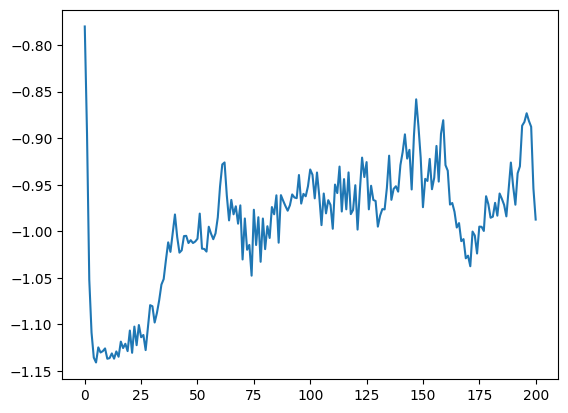

In [21]:
import matplotlib.pyplot as plt 

obs_shape = (env.observation_space.shape[0],)
action_shape = (env.action_space.shape[0],)

actor = Actor(obs_shape, action_shape)
actor.eval()

frames = []

for ep in range(10):
  obs, _ = env.reset()
  done = False
  reward_total = 0
  step_count = 0
  frames = []
  rewards = []

  while not done and step_count <= 200:
    obs_tensor = t.tensor(obs, dtype=t.float32).unsqueeze(0)
    dist = actor(obs_tensor)
    action = dist.sample().squeeze(0).detach().numpy()

    obs, reward, terminated, truncated, _ = env.step(action)
    rewards.append(reward)
    frame = env.render()
    if frame is not None:
      frames.append(frame)
    
    reward_total += reward
    done = terminated or truncated
    step_count += 1 

  print(f"Episode {ep + 1} reward: {reward_total:.2f}")
plt.plot(rewards, label=f"episode {ep + 1}")
import imageio
imageio.mimsave(f"episode_{ep+1}.mp4", frames, fps=30)

